# Flat ΛCDM Cosmological Parameter Estimation with DESI Data

This notebook derives the cosmological parameters for a **Flat ΛCDM** model by minimizing the chi-square function using only DESI data.

- **Model:** Flat ΛCDM
- **Data:** DESI BAO measurements
- **Method:**
  - Uses the [`CosmologicalDistances`](../../pyACC/cosmology/distances.py) class from the `pyACC` library
  - Uses the [`FlatLambdaCDM`](../../pyACC/cosmology/cosmology.py) class from the `pyACC` library
  - Minimization performed with `scipy.optimize.minimize`

> **Note:** With DESI data alone, only the product $H_0 \cdot r_d$ can be constrained, not $H_0$ and $r_d$ separately.

In [1]:
import sys
sys.path.append('/home/giorgio/Documents/Scuola/Università/Università_di_Genova/IV_ANNO/II_Semestre/Astrofisica Computazionale/ESAME/ToloAstroCosmoLib')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyACC.cosmology.cosmology import FlatLambdaCDM
from pyACC.cosmology.distances import CosmologicalDistances

In [2]:
import pandas as pd

#read data from a CSV file
file_data = "data.csv"
data = pd.read_csv(file_data)
data = data.astype(float)
data.head()

,z_eff,D_V / r_d,D_M / r_d,D_H / r_d,D_V / r_d_err,D_M / r_d_err,D_H / r_d_err
0,0.295,7.942,13.588,21.863,0.075,0.168,0.425
1,0.510,12.720,17.351,19.455,0.099,0.177,0.330
2,0.706,16.050,17.351,19.455,0.110,0.177,0.330
3,0.934,19.721,21.576,17.641,0.091,0.152,0.193
4,1.321,24.252,27.601,14.176,0.174,0.318,0.221


In [3]:
#I Define the cosmological model
#a Flat LambdaCDM model

model = FlatLambdaCDM(H0=70.0, Omega_m=0.3)

## Parameter Estimation and Error Estimation for Best-fit Parameters for FlatLambdaCDM using DESI Data

I will define a chi-square function for the DESI data and use `scipy.optimize.minimize` to find the best-fit parameters for the FlatLambdaCDM model.
We estimate the uncertainties on the best-fit parameters using the inverse Hessian (covariance matrix) from the minimization result. The square roots of the diagonal elements give the $1\sigma$ errors.

In [4]:
from scipy.optimize import minimize
import warnings
from numpy.linalg import LinAlgError

# I extract the relevant data
z = data["z_eff"].values
D_V_over_r_d = data["D_V / r_d"].values
D_V_over_r_d_err = data["D_V / r_d_err"].values

# Redefine the chi-square function to fit only the product H0 * r_d (since DESI data alone cannot break the degeneracy)
def chi2_prod(params):
    prod, Omega_m = params
    H0 = 70.0
    r_d = prod / H0
    model = FlatLambdaCDM(H0, Omega_m)
    distances = CosmologicalDistances(model.H)
    D_V_model = np.array([distances.volume_distance(z_running_index) for z_running_index in z])
    chi2 = np.sum(((D_V_over_r_d - D_V_model / r_d) / D_V_over_r_d_err) ** 2)
    return chi2

# Initial guess: [H0 * r_d, Omega_m]
initial_guess_prod = [70.0 * 147.0 + 200, 0.9]

# Minimize chi-square for the product
result_prod = minimize(chi2_prod, initial_guess_prod, bounds=[(60*130, 80*180), (0, 1)])

# Prepare output variables so the output is not messed up when minimization fails
best_prod, best_Omega_m_prod = np.nan, np.nan
prod_err, Omega_m_err = np.nan, np.nan
r_d_best_prod, r_d_err = np.nan, np.nan


if result_prod.success:
    best_prod, best_Omega_m_prod = result_prod.x
    # Error estimation
    if hasattr(result_prod, 'hess_inv'):
        try:
            if hasattr(result_prod.hess_inv, 'todense'):
                cov = result_prod.hess_inv.todense()
            else:
                cov = result_prod.hess_inv
            errors = np.sqrt(np.diag(cov))
            prod_err, Omega_m_err = errors[0], errors[1]
        except (AttributeError, LinAlgError, IndexError) as e:
            warnings.warn(f"Could not compute parameter errors from Hessian: {e}")


    # Calculate chi2/dof
    ndata = len(z)
    nparams = 2
    chi2 = result_prod.fun
    dof = ndata - nparams
    chi2_dof = chi2 / dof if dof > 0 else np.nan

    # Print only the best-fit values ± errors and chi2/dof
    print(f"(H0 * r_d) = {best_prod:.2f} ± {prod_err:.2f}")
    print(f"Omega_m = {best_Omega_m_prod:.4f} ± {Omega_m_err:.4f}")
    print(f"Chi2/dof = {chi2_dof:.3f}")
else:
    print("Minimization failed:", result_prod.message)

(H0 * r_d) = 10150.52 ± 1013.37
Omega_m = 0.2980 ± 0.0943
Chi2/dof = 0.928


### Notes on Error Estimation

- The errors are estimated from the inverse Hessian (covariance matrix) at the minimum.

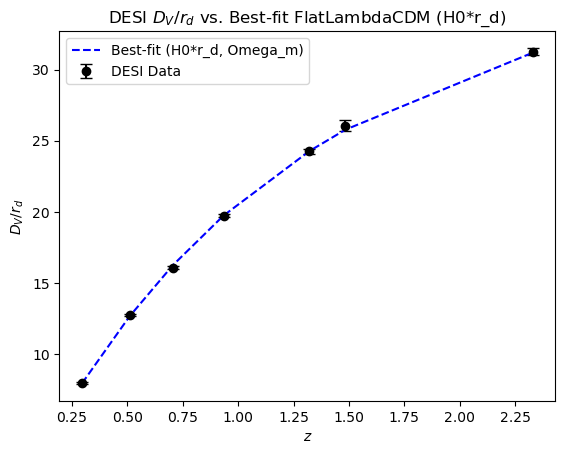

In [5]:
# Plot the fit for the product parameterization
prod_best, Omega_m_best_prod = result_prod.x
H0_fixed = 70.0
r_d_best_prod = prod_best / H0_fixed
model_best_prod = FlatLambdaCDM(H0_fixed, Omega_m_best_prod)
distances_best_prod = CosmologicalDistances(model_best_prod.H)
D_V_model_prod = np.array([distances_best_prod.volume_distance(zi) for zi in z]) / r_d_best_prod

plt.errorbar(z, D_V_over_r_d, yerr=D_V_over_r_d_err, fmt='o', label='DESI Data', color='black', capsize=4)
plt.plot(z, D_V_model_prod, 'b--', label='Best-fit (H0*r_d, Omega_m)')
plt.xlabel('$z$')
plt.ylabel(r'$D_V / r_d$')
plt.title('DESI $D_V / r_d$ vs. Best-fit FlatLambdaCDM (H0*r_d)')
plt.legend()
plt.show()

## Comparison with Literature: arXiv:2411.12020v1

<div style="background: #f6f8fa; border-left: 4px solid #0366d6; padding: 1em 1.5em; margin-bottom: 1em;">
<b>Paper Reference:</b> <a href="https://arxiv.org/abs/2411.12020v1" target="_blank">arXiv:2411.12020v1</a>  
<b>Table 2, Flat ΛCDM, DESI-only fit</b>
</div>

| Flat ΛCDM         | My $χ^2$ minimization         |My MCMC sample    | Paper|
|-------------------|-------------------------------|-------------------|----------------------------|
| $H_0 \cdot r_d$   | $10150.52 \pm 1013.37 \,\text{km/s}$   |$10147.20_{-94.55}^{+93.85}\,\text{km/s}$| ~$\,11000 \,\text{km/s}$           |
| $\Omega_m$        | $0.2980 \pm 0.0943$           | $0.2975 \pm 0.0086$       | $0.299_{+0.013}^{-0.012}$|